# Predicting Heart Disease Likelihood in Cleveland Patients Using Age and Cholesterol Levels
### Name: Alice Le

## 1. Introduction
Heart disease is a leading cause of death in the United States, with coronary artery disease being the most prevalent type. This condition often leads to heart attacks as the coronary arteries, which supply oxygen-rich blood to the body, become blocked or narrowed. When these arteries are compromised, the body's overall functioning can be severely affected due to inadequate blood flow (Cleveland Clinic, n.d.). Several risk factors contribute to the development of heart disease, including high cholesterol levels and aging (WebMD Editorial Contributors, 2023). Therefore, my proposed question is: **Can a new patient's likelihood of having heart disease be predicted based on their age and cholesterol levels?**

The study will utilize the [UCI Heart Disease Dataset from Cleveland](https://archive.ics.uci.edu/dataset/45/heart+disease) for analysis.

## 2. Methods
### 2.1 Preliminary exploratory data analysis
Import apropriate libraries and format graphs to support the report

In [1]:
set.seed(1234) 
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

# formatting graphs
options(repr.plot.width = 8, repr.plot.height = 8)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Read **processed.cleveland.data** into R using `read.csv`

In [2]:
set.seed(1234) 
#read data
cleveland <- read_csv("data/heart_disease/processed.cleveland.data")

head(cleveland)

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


63.0,1.0...2,1.0...3,145.0,233.0,1.0...6,2.0,150.0,0.0...9,2.3,3.0,0.0...12,6.0,0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


The **processed.cleveland.data** dataset lacks column names, which need to be added according to the Variables Table provided by the publisher. Additionally, the dataset contains many "?" symbols representing unknown data; these should be converted to "NA" to ensure a seamless analysis. Finally, the `num_letter` column is added to be used as a classifier.

In [3]:
set.seed(1234) 
#clean and wrangle data
cleveland_clean <- colnames(cleveland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleveland_clean [cleveland_clean == "?"] <- NA

#add num_letter
cleveland_clean <- cleveland |> mutate(num_letter = num > 0) |> mutate(num_letter = as.factor(num_letter))

head(cleveland_clean)
nrow(cleveland_clean)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_letter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3,TRUE


[1] 302

 The columns are as follow:
1. **age:** age
2. **sex:** sex (1 = male, 0 = female)
3. **cp:** chest pain type
4. **trestbps:** resting blood pressure (in mm Hg on admission to the hospital)
5. **chol:** serum cholestoral in mg/dl
6. **fbs:** fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
7. **restecg:** resting electrocardiographic results
8. **thalach:** maximum heart rate achieved
9. **exang:** whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak:** ST depression induced by exercise, relative to rest
11. **slope:** the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. **ca:** number of major vessels (0-3) coloured by flourosopy
13. **thal:** (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num:** diagnosis of heart disease (1,2,3,4 = > 50% diameter narrowing, 0 = < 50% diameter narrowing)

In this analysis, I will only be using `age` and `chol` **(cholesterol level)** to predict `num` **(diagnosis)**

To evaluate my classifier's quality, I will split the data set into 75% training and 25% testing, stratifying `num_letter`. I will use training data set to build my classifier, and testing data set to evaluate its quality and predict labels for new observations

In [4]:
set.seed(1234)
#split dataframe into 75% training and 25% testing
cleveland_split <- initial_split(cleveland_clean, prop = 0.75, strata = num_letter)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

head(cleveland_train)
nrow(cleveland_train)
head(cleveland_test)
nrow(cleveland_test)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_letter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,FALSE
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0,FALSE
52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,0,FALSE
57,1,3,150,168,0,0,174,0,1.6,1,0.0,3.0,0,FALSE


[1] 226

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num_letter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,FALSE
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1,TRUE
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0,FALSE
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0,FALSE
49,1,2,130,266,0,0,171,0,0.6,1,0.0,3.0,0,FALSE
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,0,FALSE


[1] 76

Summarizing and visualizing data can help me in identifying the general trend of the data set, particularly the relationship between `age`, `chol`, and `num_letter`

In [5]:
set.seed(1234) 
#summarize training data
cleveland_summary <- cleveland_clean |>
    group_by(num_letter) |>
    summarize(age_max = max(age), age_min = min(age), age_avg = mean(age),
              chol_max = max(chol), chol_min = min(age), chol_avg = mean(chol))
cleveland_summary

num_letter,age_max,age_min,age_avg,chol_max,chol_min,chol_avg
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,76,29,52.52147,564,29,242.6994
TRUE,77,35,56.62590,409,35,251.4748


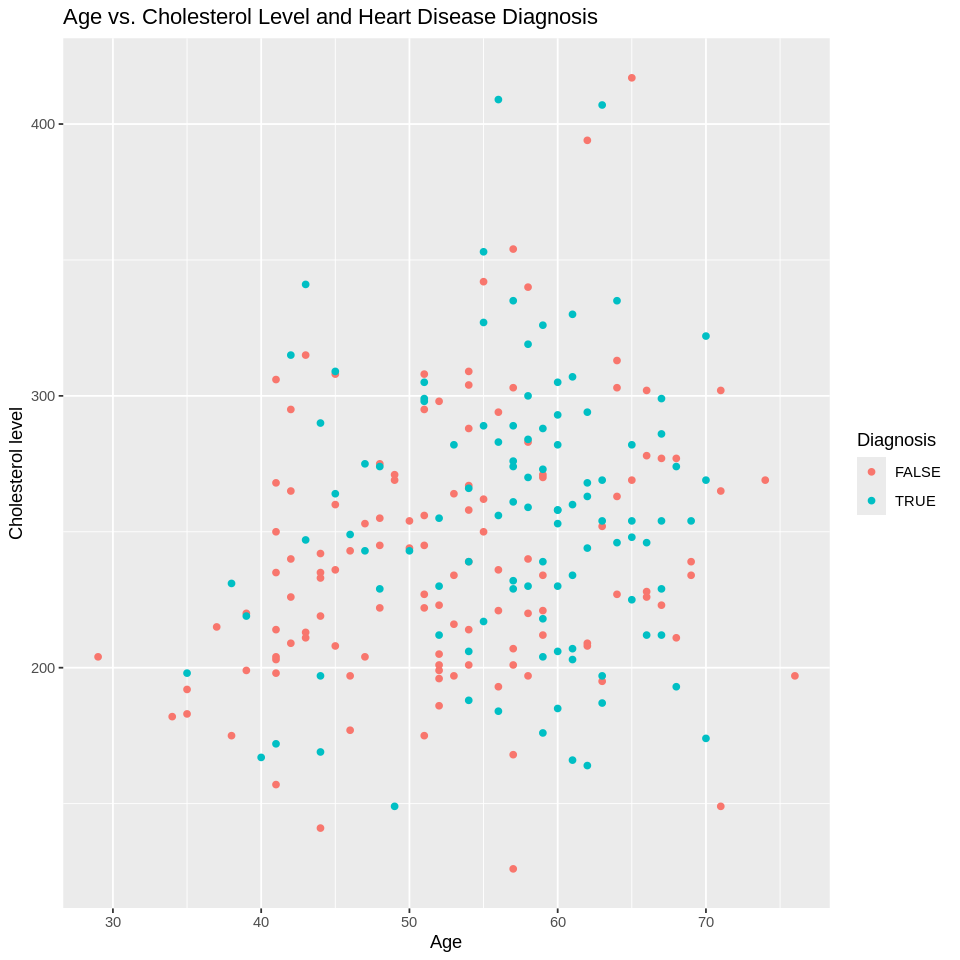

In [6]:
set.seed(1234) 
#visualize testing data
cleveland_plot <- cleveland_train |> ggplot(aes(x = age, y = chol, color = num_letter)) +
    geom_point() +
    labs(x = "Age", y = "Cholesterol level", color = "Diagnosis") +
    ggtitle("Age vs. Cholesterol Level and Heart Disease Diagnosis")
cleveland_plot

### 2.2 Tuning the classifier
K-NN classifier is sensitive to the scale of predictor variables; therefore, I will standardize `age` and `chol` using the training data set to ensure that my testing data set does not influence my model training.

In [7]:
set.seed(1234)
cleveland_recipe <- recipe(num_letter ~ age + chol, data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
cleveland_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



To predict the label of the new obervations, K-NN algorithm considers K "nearest" or "most similar" observations and uses their diagnoses to predict the new observation's diagnosis. However, we are not sure how many K to choose to maximize our accuracy; therefore, we need to have multiple training data to have a better estimate of the accuracy, which leads to better choice of K neighbors. In particular, I will have 5 validation splits by performing cross-validation.

In [13]:
set.seed(1234) 
cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = num_letter)

#create K-NN classifier with only the training set, since we are tuning the data, neighbors are set to tune()
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

#fit the knn model, create data analysis workflow
knn_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cleveland_vfold, grid = k_vals) |>
    collect_metrics()

#finding the best K
accuracies <- knn_fit |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))
head(accuracies)

neighbors,mean
<dbl>,<dbl>
91,0.6498902
92,0.6498902
87,0.6452437
88,0.6452437
79,0.6408959
80,0.6408959


Based on the table above, we can see that choosing K = 91 or K = 92 will give us the highest accuracy of 64.98%. Therefore, we need to visualize the accuracy to choose one.

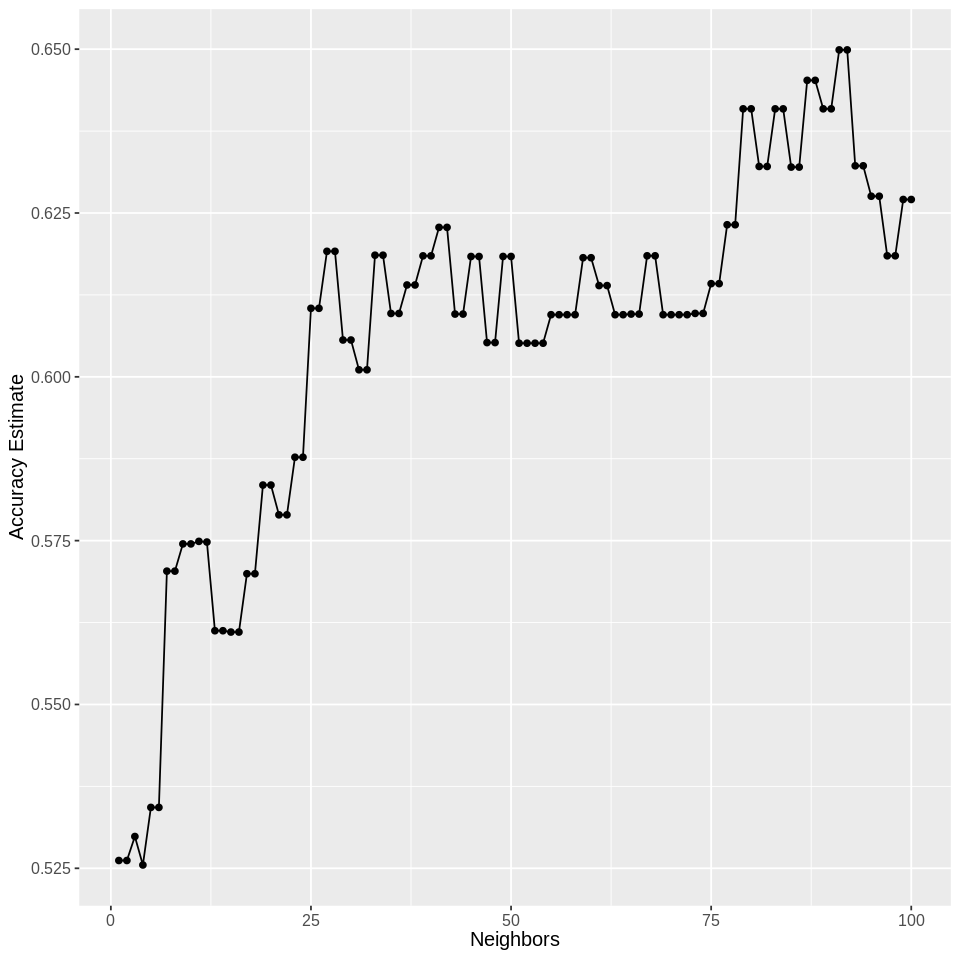

In [14]:
#visualize accuracy
set.seed(1234) 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

As we can see in the graph, K = 91 or K = 92 gives us the same accuracy; therefore, to minimize the time taken when performing classification, we will choose K = 91

### 2.3 Evaluate on test set
We need to retrain the K-NN classifier on the entire training data set using the selected number of neighbors.

In [10]:
set.seed(1234) 
cleveland_recipe <- recipe(num_letter ~ age + chol, data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#retrain K-NN classifier with K = 79
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 91) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(knn_spec) |>
  fit(data = cleveland_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(91,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.380531
Best kernel: rectangular
Best k: 91

Let's check whether `num_letter` has more TRUE or FALSE.

In [11]:
set.seed(1234) 
cleveland_proportion <- cleveland_train |>
    group_by(num_letter) |>
    summarize(num_of_patients = n()) |>
    mutate(percent = 100*num_of_patients/nrow(cleveland_train))
cleveland_proportion

num_letter,num_of_patients,percent
<fct>,<int>,<dbl>
FALSE,122,53.9823
TRUE,104,46.0177


Based on the table above, `num_letter = FALSE` is the majority with 53.98% of the patients don't have heart disease. We then make predictions and assess the accuracy of the best model on the testing data. After that we will use those predictions to assess the estimated precision and recall, and print a confusion matrix. Since I want to focus on `num_letter = TRUE`, I will set `event_level = "second"`.

In [12]:
set.seed(1234)
cleveland_test_predictions <- predict(knn_fit, cleveland_test) |>
    bind_cols(cleveland_test)

cleveland_test_predictions |>
    metrics(truth = num_letter, estimate = .pred_class) |>
    filter(.metric == "accuracy")

cleveland_test_predictions |>
    precision(truth = num_letter, estimate = .pred_class, event_level="second")

cleveland_test_predictions |>
    recall(truth = num_letter, estimate = .pred_class, event_level="second")

confusion <- cleveland_test_predictions |>
    conf_mat(truth = num_letter, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6184211


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.5882353


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5714286


          Truth
Prediction FALSE TRUE
     FALSE    27   15
     TRUE     14   20

As we can see from the table, the majority classifier has an accuracy of 53.98% while my classifier is 61.84% (47 out of 76 predictions are correct); therefore, it is safe to say that my classifier is better than the majority classifier.\
The precision of patients with heart disease is 58.82%, indicating that out of all the patients that the classifier categorized as having heart disease, 58.82% of them actually have heart disease. The recall of patients with heart disease is 57.14%, indicating that out of all the patients that actually have heart disease, the classifier only identified 57.14% of them.

## 3. Discussion
### 3.1 Summary of results
- Within this context, I would value a high recall than a high precision, which means I would want my classifier to predict false positive than false negative because I would want the patients with heart disease to be correctly identified and receive the treatment that they need. Hence, having recall less then precision is unacceptable.
#### Expected findings

#### Impact of findings

#### Future questions